In [1]:
import sys, os
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, Catalog
from pyspark.sql import DataFrame, DataFrameStatFunctions, DataFrameNaFunctions
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import Row
from subprocess import check_output

SPARK_DRIVER_HOST = check_output(["hostname", "-i"]).decode(encoding="utf-8").strip()
spark_conf = SparkConf()
spark_conf.setAll([
    ('spark.master', 'spark://spark:7077'),
    ('spark.app.name', 'myApp'),
    ('spark.submit.deployMode', 'client'),
    ('spark.ui.showConsoleProgress', 'true'),
    ('spark.eventLog.enabled', 'false'),
    ('spark.logConf', 'false'),
    ('spark.driver.bindAddress', '0.0.0.0'),
    ('spark.driver.host', SPARK_DRIVER_HOST),
    ('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0,com.amazonaws:aws-java-sdk-bundle:1.11.704,org.apache.spark:spark-hadoop-cloud_2.12:3.3.0'),
    ("spark.hadoop.fs.s3a.endpoint", 'http://minio:9000'),
    ('spark.hadoop.fs.s3a.access.key', 'minio-root-user'),
    ('spark.hadoop.fs.s3a.secret.key', 'minio-root-password'),
    ('spark.hadoop.fs.s3a.bucket.all.committer.magic.enabled', True),
    ("spark.hadoop.fs.s3a.fast.upload", True),
    ("spark.hadoop.fs.s3a.path.style.access", True),
    ("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
])
 
spark_sess          = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark_ctxt          = spark_sess.sparkContext
spark_reader        = spark_sess.read
spark_streamReader  = spark_sess.readStream
spark_ctxt.setLogLevel("WARN")

:: loading settings :: url = jar:file:/opt/bitnami/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
org.apache.spark#spark-hadoop-cloud_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ca07c21d-75ff-4c0e-a189-1b6572371215;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.0 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.704 in central
	found org.apache.spark#spark-hadoop-cloud_2.12;3.3.0 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.2 in central
	found org.apache.hadoop#hadoop-client-api;3.3.2 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.32 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bund

22/10/05 16:25:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
irisDF = spark_sess.read.option("header",True).option("inferSchema", True).csv('s3a://iris/iris.csv')

irisDF.show(truncate=False)

+---+-------------+------------+-------------+------------+-----------+
|Id |SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|Species    |
+---+-------------+------------+-------------+------------+-----------+
|1  |5.1          |3.5         |1.4          |0.2         |Iris-setosa|
|2  |4.9          |3.0         |1.4          |0.2         |Iris-setosa|
|3  |4.7          |3.2         |1.3          |0.2         |Iris-setosa|
|4  |4.6          |3.1         |1.5          |0.2         |Iris-setosa|
|5  |5.0          |3.6         |1.4          |0.2         |Iris-setosa|
|6  |5.4          |3.9         |1.7          |0.4         |Iris-setosa|
|7  |4.6          |3.4         |1.4          |0.3         |Iris-setosa|
|8  |5.0          |3.4         |1.5          |0.2         |Iris-setosa|
|9  |4.4          |2.9         |1.4          |0.2         |Iris-setosa|
|10 |4.9          |3.1         |1.5          |0.1         |Iris-setosa|
|11 |5.4          |3.7         |1.5          |0.2         |Iris-

In [15]:
irisDF.select('Species').distinct().show()

+---------------+
|        Species|
+---------------+
| Iris-virginica|
|    Iris-setosa|
|Iris-versicolor|
+---------------+



In [20]:
from pyspark.ml.feature import StringIndexer
lblIndxr = StringIndexer().setInputCol("Species").setOutputCol("SpeciesIndex")
idxRes = lblIndxr.fit(irisDF).transform(irisDF)
idxRes.where('SpeciesIndex == 2.0').show(truncate=False)

+---+-------------+------------+-------------+------------+--------------+------------+
|Id |SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|Species       |SpeciesIndex|
+---+-------------+------------+-------------+------------+--------------+------------+
|101|6.3          |3.3         |6.0          |2.5         |Iris-virginica|2.0         |
|102|5.8          |2.7         |5.1          |1.9         |Iris-virginica|2.0         |
|103|7.1          |3.0         |5.9          |2.1         |Iris-virginica|2.0         |
|104|6.3          |2.9         |5.6          |1.8         |Iris-virginica|2.0         |
|105|6.5          |3.0         |5.8          |2.2         |Iris-virginica|2.0         |
|106|7.6          |3.0         |6.6          |2.1         |Iris-virginica|2.0         |
|107|4.9          |2.5         |4.5          |1.7         |Iris-virginica|2.0         |
|108|7.3          |2.9         |6.3          |1.8         |Iris-virginica|2.0         |
|109|6.7          |2.5         |

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


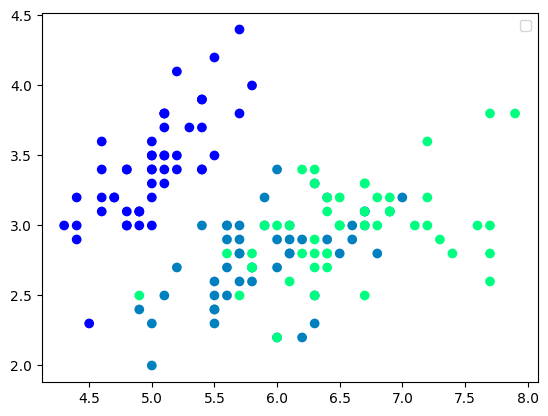

In [25]:
irisPandasDF = idxRes.toPandas()
plt.scatter(irisPandasDF["SepalLengthCm"], irisPandasDF["SepalWidthCm"], c=irisPandasDF["SpeciesIndex"], cmap='winter');
plt.legend();

In [41]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(outputCol="features").setInputCols(["SepalLengthCm", "SepalWidthCm"])
preparedDF = va.transform(idxRes)
preparedDF.show()

+---+-------------+------------+-------------+------------+-----------+------------+---------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|SpeciesIndex| features|
+---+-------------+------------+-------------+------------+-----------+------------+---------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|         0.0|[5.1,3.5]|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|         0.0|[4.9,3.0]|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|         0.0|[4.7,3.2]|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|         0.0|[4.6,3.1]|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|         0.0|[5.0,3.6]|
|  6|          5.4|         3.9|          1.7|         0.4|Iris-setosa|         0.0|[5.4,3.9]|
|  7|          4.6|         3.4|          1.4|         0.3|Iris-setosa|         0.0|[4.6,3.4]|
|  8|          5.0|         3.4|          1.5|    

In [53]:
trainingSet, testingSet = preparedDF.randomSplit([0.6, 0.4], 122)
testingSet.show()

+---+-------------+------------+-------------+------------+---------------+------------+---------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|        Species|SpeciesIndex| features|
+---+-------------+------------+-------------+------------+---------------+------------+---------+
|  2|          4.9|         3.0|          1.4|         0.2|    Iris-setosa|         0.0|[4.9,3.0]|
|  9|          4.4|         2.9|          1.4|         0.2|    Iris-setosa|         0.0|[4.4,2.9]|
| 10|          4.9|         3.1|          1.5|         0.1|    Iris-setosa|         0.0|[4.9,3.1]|
| 13|          4.8|         3.0|          1.4|         0.1|    Iris-setosa|         0.0|[4.8,3.0]|
| 14|          4.3|         3.0|          1.1|         0.1|    Iris-setosa|         0.0|[4.3,3.0]|
| 18|          5.1|         3.5|          1.4|         0.3|    Iris-setosa|         0.0|[5.1,3.5]|
| 29|          5.2|         3.4|          1.4|         0.2|    Iris-setosa|         0.0|[5.2,3.4]|
| 30|     

In [73]:
preparedDF.show()

+---+-------------+------------+-------------+------------+-----------+------------+---------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|SpeciesIndex| features|
+---+-------------+------------+-------------+------------+-----------+------------+---------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|         0.0|[5.1,3.5]|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|         0.0|[4.9,3.0]|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|         0.0|[4.7,3.2]|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|         0.0|[4.6,3.1]|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|         0.0|[5.0,3.6]|
|  6|          5.4|         3.9|          1.7|         0.4|Iris-setosa|         0.0|[5.4,3.9]|
|  7|          4.6|         3.4|          1.4|         0.3|Iris-setosa|         0.0|[4.6,3.4]|
|  8|          5.0|         3.4|          1.5|    

In [44]:
preparedDF.select('features').show()

+---------+
| features|
+---------+
|[5.1,3.5]|
|[4.9,3.0]|
|[4.7,3.2]|
|[4.6,3.1]|
|[5.0,3.6]|
|[5.4,3.9]|
|[4.6,3.4]|
|[5.0,3.4]|
|[4.4,2.9]|
|[4.9,3.1]|
|[5.4,3.7]|
|[4.8,3.4]|
|[4.8,3.0]|
|[4.3,3.0]|
|[5.8,4.0]|
|[5.7,4.4]|
|[5.4,3.9]|
|[5.1,3.5]|
|[5.7,3.8]|
|[5.1,3.8]|
+---------+
only showing top 20 rows



In [60]:
from pyspark.ml.clustering import KMeans
k_means_model = KMeans(k=3)
model = k_means_model.fit(trainingSet.select('features'))

In [65]:
item  = trainingSet.select('features').head()
result = model.transform(testingSet.select('features'))
result.show()

+---------+----------+
| features|prediction|
+---------+----------+
|[4.9,3.0]|         2|
|[4.4,2.9]|         2|
|[4.9,3.1]|         2|
|[4.8,3.0]|         2|
|[4.3,3.0]|         2|
|[5.1,3.5]|         2|
|[5.2,3.4]|         2|
|[4.7,3.2]|         2|
|[5.5,4.2]|         2|
|[4.9,3.1]|         2|
|[4.4,3.0]|         2|
|[4.6,3.2]|         2|
|[5.3,3.7]|         2|
|[5.0,3.3]|         2|
|[6.4,3.2]|         1|
|[5.5,2.3]|         0|
|[6.5,2.8]|         1|
|[4.9,2.4]|         0|
|[6.6,2.9]|         1|
|[5.9,3.0]|         0|
+---------+----------+
only showing top 20 rows



In [75]:
from pyspark.ml.linalg import Vectors
model.predict(Vectors.dense([5.0, 4.0]))
              

2

In [69]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
evaluator.setFeaturesCol("features")
evaluator.setPredictionCol("SpeciesIndex")
evaluator.evaluate(preparedDF)

0.34442330706582314